### 1) GET LIBRARY

In [31]:
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import pandas as pd

### 2) GENERATE DATA

In [32]:
np.random.seed(123)

In [33]:
def generate_toy_data(n, lam, a, b):
    '''Generate random number from poisson distribution.
    Input:
    n = number of data points to generate
    lam = lambda of the poisson distribution
    a, b = any positive coefficient (since we want to simulate demand) 
    
    Output:
    x = independent variable
    y = demand for toy data that results from a*x + b, with x ~ poisson(lam)
    '''
    x = np.random.poisson(lam, n)
    x = x.reshape((-1,1))
    
    y = a*x + b
    y = y.reshape((-1,1))
    y = y.astype(int)
    
    return x, y

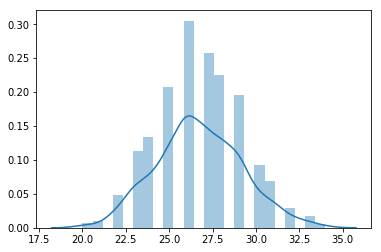

In [78]:
# generate toy data
x, y = generate_toy_data(1000, 100, 0.25, 2)

# visualize toy data
plt.figure()
sns.distplot(y)
plt.show()

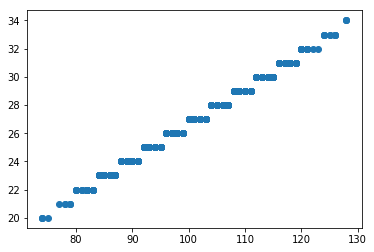

In [80]:
plt.figure()
plt.scatter(x, y)
plt.show()

### 3) IMPLEMENT SIMPLE PREDICTION

In [45]:
# split data to training and testing set
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2)

In [46]:
df_train = pd.DataFrame({'train_x': train_x.flatten(), 'train_y': train_y.flatten()})
df_test = pd.DataFrame({'test_x': test_x.flatten(), 'test_y': test_y.flatten()})

#### a) RANDOM FOREST

In [47]:
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf.fit(train_x, train_y)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [48]:
test_y_rfpred = (rf.predict(test_x)).astype(int)
err_rf = abs(test_y_rfpred - test_y)
print('Mean Absolute Error:', round(np.mean(err_rf), 2), 'degrees.')

('Mean Absolute Error:', 2.92, 'degrees.')


#### b) LINEAR REGRESSION

In [49]:
lr = LinearRegression()
lr.fit(train_x, train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [50]:
test_y_lrpred = (rf.predict(test_x)).astype(int)
err_lr = abs(test_y_lrpred - test_y)
print('Mean Absolute Error:', round(np.mean(err_lr), 2), 'degrees.')

('Mean Absolute Error:', 2.92, 'degrees.')


In [51]:
# check coefficient
print(lr.coef_)
print(lr.intercept_)

[[0.25024623]]
[1.60067184]


#### c) SUMMARIZE RESULT & CHECK GRAPH (RANDOM FOREST & LINREG)

In [52]:
df_summ = pd.DataFrame({'test_x': test_x.flatten(),
                        'test_y': test_y.flatten(), 
                        'test_y_rfpred': test_y_rfpred.flatten(), 
                        'test_y_lrpred': test_y_lrpred.flatten()})
df_summ['diff_rf_actual'] = df_summ['test_y_rfpred'] - df_summ['test_y']
df_summ['diff_lr_actual'] = df_summ['test_y_lrpred'] - df_summ['test_y']

# toy data is simple, hence prediction is rather powerful as we only have few missed prediction
# even so, in this kind of cases:
# --> we will lose potential profit if prediction < demand
# --> we will incur unnecessary cost if prediction > demand as we cannot sell the remaining goods at selling price 
df_summ[(df_summ['diff_rf_actual'] != 0) | (df_summ['diff_lr_actual'] != 0)] 

,test_x,test_y,test_y_lrpred,test_y_rfpred,diff_rf_actual,diff_lr_actual
15,84,23,22,22,-1,-1
63,84,23,22,22,-1,-1
74,84,23,22,22,-1,-1
103,76,21,20,20,-1,-1
107,84,23,22,22,-1,-1
132,116,31,30,30,-1,-1
147,116,31,30,30,-1,-1
172,128,34,32,32,-2,-2
187,116,31,30,30,-1,-1
189,126,33,32,32,-1,-1


<Figure size 432x288 with 0 Axes>

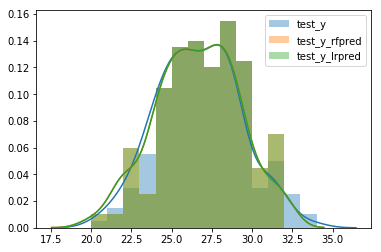

In [53]:
plt.figure()

components = [test_y, test_y_rfpred, test_y_lrpred]
labels=['test_y', 'test_y_rfpred', 'test_y_lrpred']

fig, axes = plt.subplots(1)
for component in components:
    sns.distplot(component)

axes.legend(labels=labels)    
plt.show()

### 4) STOCHASTIC PROGRAMMING
#### a) DISCRETIZING DEMAND: TO CAPTURE PROBABILITY OF EACH POSSIBLE SCENARIO

In [54]:
# capturing probability of each possible scenario can be done in many ways, 
# ranging from simple descriptive analytics to more complicated things like
# moment matching, monte carlo simulation, etc.
# we do the easiest here: do clustering to generate scenario (max 100 scenario for now)

from sklearn.cluster import KMeans

In [55]:
def cluster_1d(df, max_cluster=100):
    '''Cluster data into n different cluster where n is the minimum between unique scenario and max_cluster.
    Input:
    df = dataframe column containing scenario to cluster
    max_cluster = number of maximum cluster we want to have (default=100)
    
    Output:
    cluster_centers_df = mapping between cluster labels and its centers
    cluster_labels_df = mapping between df and its cluster labels   
    '''
    km = KMeans(n_clusters=min(len(df.unique()),max_cluster))
    km.fit(df.values.reshape(-1,1)) 
    
    # get information about center
    cluster_centers_df = pd.DataFrame(np.array(km.cluster_centers_.reshape(1,-1)[0].tolist()))
    cluster_centers_df.columns = ['cluster_centers']
    cluster_centers_df['labels'] = range(cluster_centers_df.count())
    
    # get information about labels and add information about center
    cluster_labels_df = pd.DataFrame(np.array(km.labels_))
    cluster_labels_df.columns = ['labels']
    cluster_labels_df = pd.concat([df.reset_index(drop=True), cluster_labels_df], axis=1)
    cluster_labels_df = pd.merge(cluster_labels_df, cluster_centers_df, on='labels', how='left')
    
    return cluster_centers_df, cluster_labels_df

In [56]:
def cluster_summ(df):
    '''Summarize probability for each scenario by referring to result from cluster_1d.
    Input:
    df = dataframe column containing scenario to cluster
    
    Output:
    cluster_proportion_df = dataframe containing complete information about probability for each scenario
    demand = possible scenario to happen
    weight = probability of the possible scenario to happen
    scenarios = indexing for demand
    '''
    cluster_centers_df, cluster_labels_df = cluster_1d(df)

    count_label = cluster_labels_df[['labels']].count().values[0]
    cluster_proportion_df = cluster_labels_df[['cluster_centers', 'labels']].groupby('cluster_centers').count().reset_index(drop=False)
    cluster_proportion_df['count_labels'] = count_label
    cluster_proportion_df['proportion_labels'] = cluster_proportion_df['labels'] / cluster_proportion_df['count_labels']
    cluster_proportion_df['index'] = range(1,cluster_proportion_df.shape[0] + 1)
    cluster_proportion_df['cluster_centers'] = np.round(cluster_proportion_df['cluster_centers'], decimals=(3))
    
    demand = pd.Series(cluster_proportion_df['cluster_centers'].values, index=cluster_proportion_df['index'].values).to_dict()
    weight = pd.Series(cluster_proportion_df['proportion_labels'].values, index=cluster_proportion_df['index'].values).to_dict()
    scenarios = range(1,len(cluster_proportion_df.cluster_centers.values)+1)
    
    return cluster_proportion_df, demand, weight, scenarios

In [57]:
cluster_proportion_df, demand, weight, scenarios = cluster_summ(df=df_train['train_y'])

print(demand)
print(weight)
print(scenarios)

{1: 20.0, 2: 21.0, 3: 22.0, 4: 23.0, 5: 24.0, 6: 25.0, 7: 26.0, 8: 27.0, 9: 28.0, 10: 29.0, 11: 30.0, 12: 31.0, 13: 32.0, 14: 33.0}
{1: 0.00375, 2: 0.00875, 3: 0.02625, 4: 0.0475, 5: 0.08625, 6: 0.145, 7: 0.18, 8: 0.15625, 9: 0.12, 10: 0.11375, 11: 0.0575, 12: 0.0275, 13: 0.0225, 14: 0.005}
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


#### b) USING PULP TO SOLVE STOCHASTIC PROGRAMMING

In [58]:
from pulp import *

N = 100         # maximum item to purchase
cost_price = 20 # amount paid to the supplier
sell_price = 21 # amount paid by the customer
waste_price = 0 # amount paid if we sell the remaining goods (ie. when we have more stock as prediction > demand)

In [59]:
##########################################
# DEFINE VARIABLES
##########################################

M = LpProblem("Newsvendor1", LpMaximize)

x = LpVariable('x', lowBound=0)
z = LpVariable.dicts('z', scenarios, 0)


##########################################
# DEFINE MODELS: CONSTRAINTS
##########################################

for i in scenarios:
    print(demand[i])
    print(weight[i])
    M += x <= N
    M += z[i] <= x
    M += z[i] <= demand[i]

    
##########################################
# DEFINE MODELS: OBJECTIVE
##########################################

M += sum(weight[i] * (sell_price * z[i] + waste_price * (x - z[i])) for i in scenarios) - (cost_price * x) 
M.solve()


##########################################
# PRINT RESULTS
##########################################

print("Status = %s" % LpStatus[M.status])

print("%s = %f" % (x.name, x.varValue))
for i in scenarios:
    print("%s = %f" % (z[i].name, z[i].varValue))
print("Objective = %f" % (M.objective.value()))



20.0
0.00375
21.0
0.00875
22.0
0.02625
23.0
0.0475
24.0
0.08625
25.0
0.145
26.0
0.18
27.0
0.15625
28.0
0.12
29.0
0.11375
30.0
0.0575
31.0
0.0275
32.0
0.0225
33.0
0.005
Status = Optimal
x = 23.000000
z_1 = 20.000000
z_2 = 21.000000
z_3 = 22.000000
z_4 = 23.000000
z_5 = 23.000000
z_6 = 23.000000
z_7 = 23.000000
z_8 = 23.000000
z_9 = 23.000000
z_10 = 23.000000
z_11 = 23.000000
z_12 = 23.000000
z_13 = 23.000000
z_14 = 23.000000
Objective = 21.845000


#### c) CHECK AS TABLE (MANUAL CALCULATION): TO SEE CLEARLY WHAT HAPPENS

In [60]:
def result_summ(cluster_proportion_df, demand, weight, sell_price, cost_price, waste_price):
    '''Summarize result by comparing possible scenario (example_df) with its possible execution (purchase_df).
    We want to look how much profit we can get given a pair of scenario and its execution, 
    weighted with the probability of each scenario to happen.
    Input:
    cluster_proportion_df = dataframe containing complete information about probability for each scenario
    demand = possible scenario to happen
    weight = probability of the possible scenario to happen
    cost_price = amount paid to the supplier
    sell_price = amount paid by the customer
    waste_price = amount paid if we sell the remaining goods

    Output:
    example_df = dataframe after cross join between possible scenario and possible execution
    example_df_summ = summary of example_df to obtain total expected profit per possible execution
    '''
    
    # get the basic df: purchase_df for the demand and example_df for the possible scenario execution
    purchase_df = pd.DataFrame({'key': 0, 'item_to_purchase': demand})
    example_df = pd.DataFrame({'key': 0, 'item_to_sell': cluster_proportion_df['cluster_centers'], 
                               'probability': cluster_proportion_df['proportion_labels']})
    example_df = example_df.merge(purchase_df, on='key', how='outer')
    example_df = example_df.drop('key', axis=1).sort_values(['item_to_purchase', 'item_to_sell'])
    
    example_df['total_revenue'] = example_df[['item_to_sell', 'item_to_purchase']].min(axis=1) * sell_price
    example_df['total_cost'] = example_df['item_to_purchase'] * cost_price
    example_df['total_profit'] = (example_df['total_revenue'] - example_df['total_cost'])
    
    example_df['total_weighted_profit'] = example_df['probability'] * example_df['total_profit']
    example_df['total_cumsum_profit'] = example_df.groupby('item_to_purchase')['total_weighted_profit'].cumsum()

    example_df_summ = example_df.groupby('item_to_purchase', as_index=False)['total_weighted_profit'].sum()
    
    return example_df, example_df_summ

In [76]:
example_df, example_df_summ = result_summ(cluster_proportion_df=cluster_proportion_df, demand=demand, weight=weight, 
                                          sell_price=sell_price, cost_price=cost_price, waste_price=waste_price)
example_df

,item_to_sell,probability,item_to_purchase,total_revenue,total_cost,total_profit,total_weighted_profit,total_cumsum_profit
0,20.0,0.00375,20.0,420.0,400.0,20.0,0.07500,0.07500
14,21.0,0.00875,20.0,420.0,400.0,20.0,0.17500,0.25000
28,22.0,0.02625,20.0,420.0,400.0,20.0,0.52500,0.77500
42,23.0,0.04750,20.0,420.0,400.0,20.0,0.95000,1.72500
56,24.0,0.08625,20.0,420.0,400.0,20.0,1.72500,3.45000
70,25.0,0.14500,20.0,420.0,400.0,20.0,2.90000,6.35000
84,26.0,0.18000,20.0,420.0,400.0,20.0,3.60000,9.95000
98,27.0,0.15625,20.0,420.0,400.0,20.0,3.12500,13.07500
112,28.0,0.12000,20.0,420.0,400.0,20.0,2.40000,15.47500
126,29.0,0.11375,20.0,420.0,400.0,20.0,2.27500,17.75000


#### d) VISUAL CHECK

In [62]:
# limit the table, we don't want to be overwhelmed
temp = example_df[(example_df['item_to_purchase'] >= 20) & (example_df['item_to_purchase'] <= 25)]
temp.loc[:,'item_to_purchase'] = temp['item_to_purchase'].astype('str')

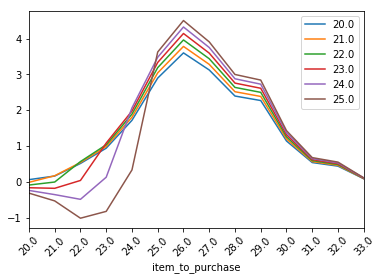

In [63]:
# check the weighted profit per possible scenario: 
# we can see how higher execution causes greater loss during weak demand and hence,
# higher execution number has difficulty in bouncing the profit up 

fig, ax = plt.subplots()

for i in temp['item_to_purchase'].unique():
    temp[temp['item_to_purchase'] == i].plot.line(x='item_to_purchase', y='total_weighted_profit', ax=ax, label=str(i))
plt.xticks(range(0,np.unique(temp['item_to_sell']).shape[0]),np.unique(temp['item_to_sell']),rotation=45)
plt.show()

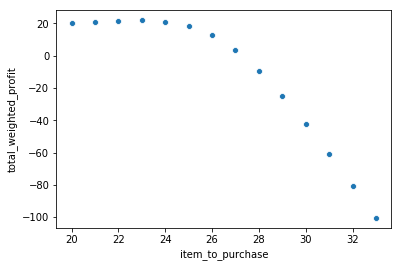

In [64]:
# check the total expected profit, which comes from all possible profit 
# and weighted by the probability of the scenario to happen
plt.figure()
sns.scatterplot(x='item_to_purchase', y='total_weighted_profit', data=example_df_summ)
plt.show()

### 5) PREDICTION + STOCHASTIC PROGRAMMING
#### a) BOOTSTRAPPING

In [68]:
size_bstrap = 50
iter = 100
idx_check = 172
test_y_bstrap = []
coef_bstrap = []
intercept_bstrap = []

for i in range(iter):
    
    # sampling with replacement
    idx = np.random.choice(np.arange(0,train_x.shape[0]), size_bstrap, replace=True)
    train_x_temp = train_x[idx]
    train_y_temp = train_y[idx]
    
    # do linear regression
    lr_bstrap = LinearRegression()
    lr_bstrap.fit(train_x_temp, train_y_temp)
    
    # get coefficient and intercept
    coef_bstrap.append(lr_bstrap.coef_)
    intercept_bstrap.append(lr_bstrap.intercept_)
    
    # get result, only for intended index idx_check
    # test_y_bstrap.append((lr_bstrap.predict(test_x)[idx_check][0]).astype(int))
    result_temp = np.rint(lr_bstrap.intercept_ + lr_bstrap.coef_ * test_x[idx_check])[0,0]
    test_y_bstrap.append(result_temp)
    

In [95]:
result_bstrap = pd.DataFrame({'test_y_bstrap': test_y_bstrap})
result_bstrap['test_x_bstrap'] = test_x[idx_check][0]
result_bstrap

,test_y_bstrap,test_x_bstrap
0,34.0,128
1,34.0,128
2,34.0,128
3,34.0,128
4,34.0,128
5,33.0,128
6,34.0,128
7,34.0,128
8,34.0,128
9,34.0,128


In [94]:
result_bstrap_summ = result_bstrap.groupby('test_y_bstrap').count().reset_index(drop=False)
result_bstrap_summ

,test_y_bstrap,test_x_bstrap
0,33.0,13
1,34.0,87


#### b) DISCRETIZING DEMAND

In [70]:
cluster_proportion_df_bstrap, demand_bstrap, weight_bstrap, scenarios_bstrap = cluster_summ(df=result_bstrap['test_y_bstrap'])

print(demand_bstrap)
print(weight_bstrap)
print(scenarios_bstrap)

{1: 33.0, 2: 34.0}
{1: 0.13, 2: 0.87}
[1, 2]


#### c) USING PULP TO SOLVE STOCHASTIC PROGRAMMING

In [91]:
##########################################
# DEFINE VARIABLES
##########################################

M_bstrap = LpProblem("Newsvendor2", LpMaximize)

x_bstrap = LpVariable('x_bstrap', lowBound=0)
z_bstrap = LpVariable.dicts('z_bstrap', scenarios_bstrap, 0)


##########################################
# DEFINE MODELS: CONSTRAINTS
##########################################

for i in scenarios_bstrap:
    print(demand_bstrap[i])
    print(weight_bstrap[i])
    M_bstrap += x_bstrap <= N
    M_bstrap += z_bstrap[i] <= x_bstrap
    M_bstrap += z_bstrap[i] <= demand_bstrap[i]

    
##########################################
# DEFINE MODELS: OBJECTIVE
##########################################

M_bstrap += sum(weight_bstrap[i] * (sell_price * z_bstrap[i] + waste_price * (x_bstrap - z_bstrap[i])) for i in scenarios_bstrap) - (cost_price * x_bstrap) 
M_bstrap.solve()


##########################################
# PRINT RESULTS
##########################################

print("Status = %s" % LpStatus[M_bstrap.status])

print("%s = %f" % (x_bstrap.name, x_bstrap.varValue))
for i in scenarios_bstrap:
    print("%s = %f" % (z_bstrap[i].name, z_bstrap[i].varValue))
print("Objective = %f" % (M_bstrap.objective.value()))



33.0
0.13
34.0
0.87
Status = Optimal
x_bstrap = 33.000000
z_bstrap_1 = 33.000000
z_bstrap_2 = 33.000000
Objective = 33.000000


#### d) CHECK AS TABLE (MANUAL CALCULATION): TO SEE CLEARLY WHAT HAPPENS

In [93]:
example_df_bstrap, example_df_summ_bstrap = result_summ(cluster_proportion_df=cluster_proportion_df_bstrap, 
                                                        demand=demand_bstrap, weight=weight_bstrap, 
                                                        sell_price=sell_price, cost_price=cost_price, 
                                                        waste_price=waste_price)
example_df_bstrap.head(n=5)

,item_to_sell,probability,item_to_purchase,total_revenue,total_cost,total_profit,total_weighted_profit,total_cumsum_profit
0,33.0,0.13,33.0,693.0,660.0,33.0,4.29,4.29
2,34.0,0.87,33.0,693.0,660.0,33.0,28.71,33.00
1,33.0,0.13,34.0,693.0,680.0,13.0,1.69,1.69
3,34.0,0.87,34.0,714.0,680.0,34.0,29.58,31.27


In [92]:
# optimal decision will only change if we increase sales_price (eg. sales_price = 23)
example_df_bstrap, example_df_summ_bstrap = result_summ(cluster_proportion_df=cluster_proportion_df_bstrap, 
                                                        demand=demand_bstrap, weight=weight_bstrap, 
                                                        sell_price=23, cost_price=cost_price, 
                                                        waste_price=waste_price)
example_df_bstrap.head(n=5)

,item_to_sell,probability,item_to_purchase,total_revenue,total_cost,total_profit,total_weighted_profit,total_cumsum_profit
0,33.0,0.13,33.0,759.0,660.0,99.0,12.87,12.87
2,34.0,0.87,33.0,759.0,660.0,99.0,86.13,99.00
1,33.0,0.13,34.0,759.0,680.0,79.0,10.27,10.27
3,34.0,0.87,34.0,782.0,680.0,102.0,88.74,99.01


#### d) VISUAL CHECK

In [83]:
example_df_bstrap.loc[:,'item_to_purchase'] = example_df_bstrap['item_to_purchase'].astype('str')

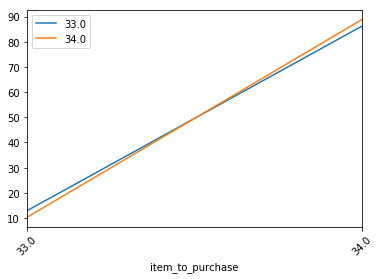

In [84]:
# check the weighted profit per possible scenario: 
# we can see how higher execution causes greater loss during weak demand and hence,
# higher execution number has difficulty in bouncing the profit up 

fig, ax = plt.subplots()

for i in example_df_bstrap['item_to_purchase'].unique():
    example_df_bstrap[example_df_bstrap['item_to_purchase'] == i].plot.line(x='item_to_purchase', y='total_weighted_profit', ax=ax, label=str(i))
plt.xticks(range(0,np.unique(example_df_bstrap['item_to_sell']).shape[0]),np.unique(example_df_bstrap['item_to_sell']),rotation=45)
plt.show()

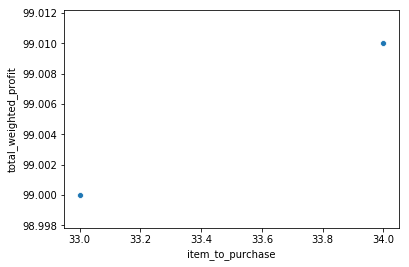

In [85]:
# check the total expected profit, which comes from all possible profit 
# and weighted by the probability of the scenario to happen
plt.figure()
sns.scatterplot(x='item_to_purchase', y='total_weighted_profit', data=example_df_summ_bstrap)
plt.show()